In [1]:
from typing import TypedDict

from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import Attachments, ContentResource, ShortAnswer, Task


class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # clues, findings and answers to the previous subtasks 
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all files that might be needed to execute the task 
    attachments: list[Attachments]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str  

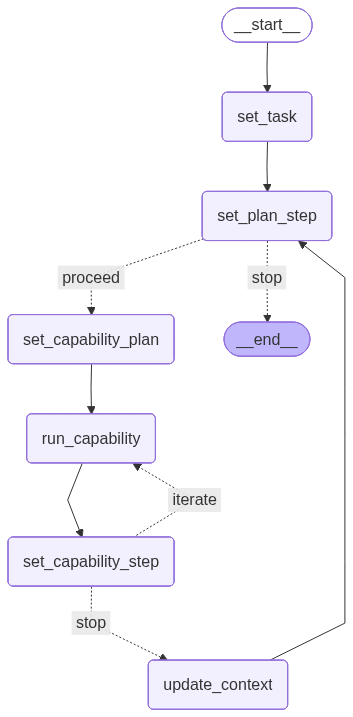

In [ ]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


workflow = StateGraph(state_schema=ExecutionState)

def init_state(ask: str, attachments: str = None, resources: str = None) -> ExecutionState:
    # TODO: should I be using LLM to convert attachments/resources to acceptable format?
    # TODO: implement proper handling of attachments and resources 
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=list(),
        attachments=list(),
    )

def set_task(state: ExecutionState) -> ExecutionState: 
    question_task = state["ask"]
    task_plan_response = create_plan(question_task)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    state["task"] = task

    return state

def set_plan_step(state: ExecutionState) -> ExecutionState: 
    """  
    Determine which state is being executed. 
    """
    if state["step"] is None: 
        state["step"] = 0 
    else:
        state["step"] += 1
         
    return state

def check_plan_completion(state: ExecutionState) -> str:
    short_answer = construct_short_answer(state["task"].objective, state["context"] )
    print("\nCurrent answer is:\n", short_answer, "\n")
    # TODO: might incorporate early stopping if answer is found
    # if not short_answer | len(short_answer.answer) == 0 | short_answer.answer.lower() != "not found":
        
    plan_length = len(state["task"].plan)
    if state["step"] < plan_length:
        return "proceed"
    else:
        return "stop"

def set_capability_plan(state: ExecutionState) -> ExecutionState: 
    state["capability_plan"] = determine_capabilities(state["task"].plan[state["step"]])
    state["capability_plan_step"] = 0

    return state

def set_capability_step(state: ExecutionState) -> ExecutionState:
    if state["capability_plan_step"] is None:
        state["capability_plan_step"] = 0 
    else:
        state["capability_plan_step"] += 1 

    return state

def check_capability_step(state:ExecutionState) -> ExecutionState: 
    capability_plan_length = len(state["capability_plan"].subplan)
    if state["capability_plan_step"] < capability_plan_length:
        # run the next capability step
        return "iterate"        
    else: 
        # signal that we need to move over to the next state
        return "stop" 

def run_capability(state: ExecutionState) -> ExecutionState: 
    capability_agent = state["capability_plan"].subplan[state["capability_plan_step"]]
    output = None
    match capability_agent:
        case AgentCapabilityDeepWebSearch():
            output = capability_agent.run()
        case AgentCapabilityUnstructuredDataProcessor():
            output = capability_agent.run(state["resources"])
        case _:
            print("DEBUG | run_capability | Call to unidentified agent: ", capability_agent)
    answers = output.answers
    resources = output.resources
    attachments = output.attachments 

    # FIXME: delete this  
    print("DEBUG | run_capability | Reponse output: ", output)

    if answers:
        state["answers"].extend(answers)
    if attachments:
        state["attachments"].extend(attachments)
    if resources:
        state["resources"].extend(resources)

    return state

def update_context(state: ExecutionState) -> ExecutionState:
    asked = state["task"].plan[state["step"]]
    found = state['answers']
    context_delta = "\n" + str(
        {
            "asked": asked,
            "found": found,
        }
    ) 
    state["context"] += context_delta

    # TODO: IMPORTANT  need to save them somewhere else? 
    state["resources"] = list()
    return state

FILE_NAME_SAVED_STATE = "state.pkl"
def save_state(state: ExecutionState):
    import pickle
    
    with open(FILE_NAME_SAVED_STATE, "wb") as f:
        pickle.dump(state, f)

def load_state(path: str = FILE_NAME_SAVED_STATE) -> ExecutionState:
    import pickle

    with open(path, "rb") as f:
        return pickle.load(f)


workflow.add_node("set_task", set_task)
workflow.add_node("set_plan_step", set_plan_step)
workflow.add_node("set_capability_plan", set_capability_plan)
workflow.add_node("run_capability", run_capability)
workflow.add_node("set_capability_step", set_capability_step)
workflow.add_node("update_context", update_context)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "set_plan_step")
workflow.add_conditional_edges(
    "set_plan_step",
    check_plan_completion,
    {
        "proceed": "set_capability_plan",
        "stop": END,
    }
)
workflow.add_edge("set_capability_plan", "run_capability")
workflow.add_edge("run_capability", "set_capability_step")
workflow.add_conditional_edges(
    "set_capability_step", 
    check_capability_step,
    {
        "iterate":"run_capability",
        "stop": "update_context",
    }
)
workflow.add_edge("update_context", "set_plan_step")

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
# Test part nodes & logging
import logging

import mlflow

from generalist.models.core import MLFlowLLMWrapper
from generalist.utils import pprint
from generalist.tools import planning, web_search, text_processing

logging.getLogger().setLevel(logging.INFO)

mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
# MONKEY PATCH the llm call
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)


question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."
initial_state = init_state(question)

state = set_task(initial_state)
pprint(state["task"].__str__())

2025-09-05 23:05:05,339 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"
2025-09-05 23:05:17,485 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/348793489932515010/runs/c148633028d34b0cbc5ac368912547d0
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010
Task(question='Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M.',
objective='Identify the role played by the actor who portrayed Ray in the Polish-language version of Everybody Loves Raymond in
the film Magda M.', plan=['Research the name of the actor who played Ray in the Polish-language version of Everybody Loves
Raymond', "Use the identified actor's name to gather information about their roles, focusing on the film Magda M."])


In [4]:
raise

RuntimeError: No active exception to reraise

In [10]:
# Test 1
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)


question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

initial_state = init_state(question)
generalist_graph.invoke(initial_state)

2025-09-05 23:48:32,314 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/348793489932515010/runs/f7055cb00c924a54a33aeb7c483b7129
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-05 23:48:37,787 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"



Current answer is:
 ShortAnswer(answer='not found', clarification='The provided list does not contain any information about an actor who played Ray in the Polish-language version of Everybody Loves Raymond or their role in Magda M.') 



2025-09-05 23:48:50,885 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/348793489932515010/runs/d1f987c296334be59eb6d7ac7d2b7299
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-05 23:48:52,804 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/348793489932515010/runs/a0e881116a2f4c95850c1988019db404
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010

Generated queries: ['Polish cast Everybody Loves Raymond', 'Ray Polish Everybody Loves Raymond']


2025-09-05 23:48:54,045 - httpx - INFO - HTTP Request: GET https://en.wikipedia.org/wiki/Wszyscy_kochaj%C4%85_Romana "HTTP/1.1 200 OK"



Found 1 unique web resources.
DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=None, resources=[ContentResource(provided_by='web_search', content='Wszyscy kochają Romana - Wikipedia Jump to content From Wikipedia, the free encyclopedia 2011 Polish TV series or program Wszyscy kochają Romana Genre Sitcom Written by Katarzyna Krzysztopik Karol Klementewic Directed by Jerzy Bogajewicz Starring Bartłomiej Kasprzykowski Aneta Todorczuk-Perchuć Anna Seniuk Joachim Lamża Tede Country of origin Poland Original language Polish No. of seasons 1 No. of episodes 4 Production Running time 22 minutes Original release Network TVN Release 2\xa0September\xa02011 \xa0( 2011-09-02 ) Wszyscy kochają Romana ( Everybody Loves Roman ) is a Polish television sitcom that premiered on TVN on 2 September 2011. [ 1 ] [ 2 ] The series is a Polish-language adaptation of the American Emmy Awards winner, Everybody Loves Raymond and stars Bartłomiej Kasprzykowski as the titular Roman, a newspap

2025-09-05 23:49:04,670 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/ecbc7d291b2b47058f5f9b5431846223
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-05 23:49:11,403 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=[ShortAnswer(answer='Bartłomiej Kasprzykowski', clarification="The text directly states that Bartłomiej Kasprzykowski plays the character Roman (Ray) in 'Wszyscy kochają Romana'.")], resources=None, attachments=None)


2025-09-05 23:49:18,131 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"



Current answer is:
 ShortAnswer(answer='Bartłomiej Kasprzykowski', clarification="The text directly states that Bartłomiej Kasprzykowski plays the character Roman (Ray) in 'Wszyscy kochają Romana'.") 



2025-09-05 23:49:30,746 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/348793489932515010/runs/eb468fe305d0453eb59a34061b1d3c46
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-05 23:49:32,884 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/348793489932515010/runs/ae13ef9bbfe648acaa7537d7e3bff68a
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010

Generated queries: ["Film 'Magda M.' cast", 'Cast of Magda M. film']


2025-09-05 23:49:35,389 - httpx - INFO - HTTP Request: GET https://en.wikipedia.org/wiki/Magda_M. "HTTP/1.1 200 OK"



Found 2 unique web resources.


2025-09-05 23:49:36,233 - httpx - INFO - HTTP Request: GET https://watch.plex.tv/show/magda-m "HTTP/1.1 200 OK"


DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=None, resources=[ContentResource(provided_by='web_search', content='Magda M. - Wikipedia Jump to content From Wikipedia, the free encyclopedia 2005 TV series or program Magda M. Genre Soap opera Created by Michał Kwieciński , Dorota Chamczyk Written by Radosław Figura (Head writer) Starring Joanna Brodzik Paweł Małaszyński Ewa Kasprzyk Bartłomiej Świderski Daria Widawska Krzysztof Stelmaszyk Katarzyna Herman Bartek Kasprzykowski Katarzyna Bujakiewicz Szymon Bobrowski Jacek Braciak Patrycja Durska No. of episodes 55 Production Executive producer Dariusz Gąsiorowski Running time 42–47 minutes Original release Network TVN Release September 6, 2005 ( 2005-09-06 ) \xa0– June 5, 2007 ( 2007-06-05 ) Magda M. ( Polish pronunciation: [ˈmaɡda ˈɛm] ) was a Polish soap opera which aired on TVN from 2005 to 2007. Plot [ edit ] Magdalena Miłowicz is a young lawyer who seems to be a little lost in her love life, until she meets P

2025-09-05 23:50:00,659 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_task_with_text_llm at: http://localhost:5000/#/experiments/348793489932515010/runs/21a95d37977d405980628089a9b72677
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010


2025-09-05 23:50:06,571 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


DEBUG | run_capability | Reponse output:  AgentCapabilityOutput(answers=[ShortAnswer(answer='not found', clarification='The provided list mentions television series roles, not film roles. No specific film role is mentioned for Bartłomiej Kasprzykowski.')], resources=None, attachments=None)


2025-09-05 23:50:14,370 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"



Current answer is:
 ShortAnswer(answer='not found', clarification="The provided list identifies Bartłomiej Kasprzykowski as playing Ray in 'Wszyscy kochają Romana', but does not provide any information about his role in Magda M.") 



{'ask': 'Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M.',
 'task': Task(question='Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M.', objective='Identify the actor who played Ray in the Polish-language version of Everybody Loves Raymond and determine their role in Magda M.', plan=['Gather information on the Polish cast of the Polish-language version of Everybody Loves Raymond to identify the actor who played Ray', 'Research the film Magda M. to find out which roles this identified actor portrayed']),
 'step': 2,
 'context': '\n{\'asked\': \'Gather information on the Polish cast of the Polish-language version of Everybody Loves Raymond to identify the actor who played Ray\', \'found\': [ShortAnswer(answer=\'Bartłomiej Kasprzykowski\', clarification="The text directly states that Bartłomiej Kasprzykowski plays the character Roman (Ray) in \'Wszyscy kochają Romana\'.")]}\

Trace(trace_id=baaa1d41b17b49819633ba91e706ed73)

In [ ]:
# ans = web_search.web_search(question)

# from ddgs import DDGS

# DDGS

2025-09-05 23:47:09,741 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/348793489932515010/runs/4ce067441e824a90a65cf627b2998fce
🧪 View experiment at: http://localhost:5000/#/experiments/348793489932515010

Generated queries: ['actor who played ray in polish everybody loves ray', 'actor from poland in magda m series']


2025-09-05 23:47:11,406 - httpx - INFO - HTTP Request: GET https://en.wikipedia.org/wiki/Wszyscy_kochaj%C4%85_Romana "HTTP/1.1 200 OK"



Found 2 unique web resources.


2025-09-05 23:47:11,867 - httpx - INFO - HTTP Request: GET https://en.m.wikipedia.org/wiki/Jakub_Zdr%C3%B3jkowski "HTTP/1.1 200 OK"


In [ ]:
# Task 2 
question = "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"